To configure AWS credentials in Google Colab, you can use the secrets manager. Click on the "🔑" icon in the left sidebar, and add your AWS Access Key ID and AWS Secret Access Key. Name them `AWS_ACCESS_KEY_ID` and `AWS_SECRET_ACCESS_KEY` respectively.

Then you can access your S3 bucket:


Click here to opern this notebook in Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tsekatm/aws-python-data-engineering-challenge/blob/main/load_shedding_analysis.ipynb)
# South Africa Load Shedding Analysis
## AWS Data Engineering Challenge

**Author**: Tebogo Tseka  
**Date**: 03 July 2025  
**Time**: 19:00 SAST.  
**Zoom Link**:  [bit.ly/3VmV3CK](https://bit.ly/3VmV3CK)  
**Meetup Link / Register here**: [meetup.com/mzansi-aws](https://meetup.com/mzansi-aws)

**Objective**: Analyze South Africa's load shedding patterns and demonstrate AWS S3 capabilities

### Features
- AWS S3 integration for data storage
- Data analysis of electricity crisis patterns
- Machine learning predictions
- Interactive visualizations
- Business intelligence insights

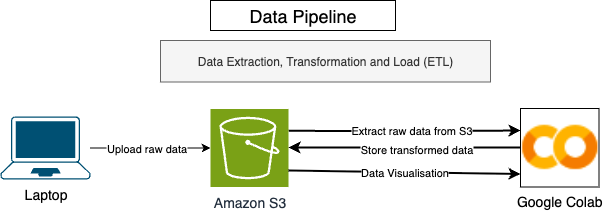

In [ ]:
# Install required packages
# Q1 Why do we always start with pip install?
!pip install boto3 pandas numpy matplotlib seaborn plotly scikit-learn

# Import libraries
# Powerful data manipulation and analysis library - think Excel but for programmers
import pandas as pd

# Numerical computing library for fast mathematical operations on arrays and matrices
import numpy as np

# Basic plotting library for creating static charts, graphs, and visualizations
import matplotlib.pyplot as plt

# Statistical visualization library built on matplotlib - makes beautiful plots with less code
import seaborn as sns

# Interactive visualization library for creating dynamic, web-ready charts and dashboards
import plotly.express as px

# Q2 Why do we use Boto3?
import boto3
from botocore.exceptions import ClientError, NoCredentialsError

import json
import os
from datetime import datetime

# Q3 What is SKLearn?
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages installed successfully!")

In [ ]:
from google.colab import userdata
import os

os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')

print("✅ AWS credentials configured!")

After running the cell above, you can run the next cell that initializes the AWSConfig class.

In [ ]:
# AWS Configuration Class
# Holds all configuration data for this notebook to be able to connect to AWS
# Thing like region, bucket name
# You can put more global config that you want to reuse in the notebook
# Q4 Why is it a good idea to do this?
class AWSConfig:
    def __init__(self):
        self.region = 'us-east-1'
        # Use the correct bucket name from your S3 console
        self.bucket_name = 'aws-python-data-engineering-challenge'

        try:
            self.s3_client = boto3.client('s3', region_name=self.region)
            self.s3_client.list_buckets()
            print(f"✅ AWS S3 connected! Region: {self.region}")
            print(f"🪣 Target bucket: {self.bucket_name}")
        except NoCredentialsError:
            print("❌ AWS credentials not found. Please configure AWS CLI.")
            print("Run: aws configure")
        except Exception as e:
            print(f"❌ AWS error: {e}")

    def verify_bucket_access(self):
        """Verify we can access the existing bucket"""
        try:
            self.s3_client.head_bucket(Bucket=self.bucket_name)
            print(f"✅ Successfully connected to existing bucket: {self.bucket_name}")
            return True
        except ClientError as e:
            error_code = e.response['Error']['Code']
            if error_code == '404':
                print(f"❌ Bucket not found: {self.bucket_name}")
            elif error_code == '403':
                print(f"❌ Access denied to bucket: {self.bucket_name}")
            else:
                print(f"❌ Error accessing bucket: {e}")
            return False

# Initialize AWS (connects to existing bucket)
aws = AWSConfig()
aws.verify_bucket_access()

In [ ]:
# S3 Manager Class
# Manages interactions with S3 using the above config
# Q5 Why do we need this class?
# Q6 Based on the code below what does this class do?
class S3Manager:
    def __init__(self, aws_config):
        self.s3 = aws_config.s3_client
        self.bucket = aws_config.bucket_name

    def upload_df(self, df, key):
        try:
            csv_data = df.to_csv(index=False)
            #This line uploads the CSV above to S3 using S3 client.
            self.s3.put_object(
                Bucket=self.bucket,
                Key=key,
                Body=csv_data.encode('utf-8')
            )
            print(f"✅ Uploaded: {key}")
            return f"s3://{self.bucket}/{key}"
        except Exception as e:
            print(f"❌ Upload failed: {e}")

    def download_df(self, key):
        try:
            obj = self.s3.get_object(Bucket=self.bucket, Key=key)
            df = pd.read_csv(obj['Body'])
            print(f"✅ Downloaded: {key}")
            return df
        except Exception as e:
            print(f"❌ Download failed: {e}")

    def list_files(self):
        try:
            response = self.s3.list_objects_v2(Bucket=self.bucket)
            if 'Contents' in response:
                files = [obj['Key'] for obj in response['Contents']]
                print(f"📁 Files in {self.bucket}:")
                for f in files:
                    print(f"  📄 {f}")
                return files
            else:
                print("📁 Bucket is empty")
                return []
        except Exception as e:
            print(f"❌ List failed: {e}")

# Initialize S3 Manager
s3_mgr = S3Manager(aws)
print("🔧 S3 Manager ready!")

In [ ]:
# Generate sample load shedding data
# Do not run this code. It is here just in cases the next code block does not work.
print("🔧 Creating sample data...")

#
np.random.seed(42)

#
dates = pd.date_range('2015-01-01', '2020-12-31', freq='6H')

# Create realistic load shedding patterns
loadshedding_data = pd.DataFrame({
    'created_at': dates,
    'stage': np.random.choice([0, 1, 2, 3, 4], len(dates), p=[0.6, 0.2, 0.1, 0.07, 0.03])
})

# Add seasonal patterns (more load shedding in winter)
winter_mask = loadshedding_data['created_at'].dt.month.isin([6, 7, 8])
loadshedding_data.loc[winter_mask, 'stage'] = np.minimum(
    loadshedding_data.loc[winter_mask, 'stage'] +
    np.random.binomial(1, 0.3, winter_mask.sum()), 4
)

# Add peak hour patterns
peak_hours = loadshedding_data['created_at'].dt.hour.isin([6, 7, 8, 17, 18, 19])
loadshedding_data.loc[peak_hours, 'stage'] = np.minimum(
    loadshedding_data.loc[peak_hours, 'stage'] +
    np.random.binomial(1, 0.2, peak_hours.sum()), 4
)

print(f"✅ Generated {len(loadshedding_data)} load shedding records")
print("\n📊 Sample data:")
print(loadshedding_data.head())
print(f"\nDate range: {loadshedding_data['created_at'].min()} to {loadshedding_data['created_at'].max()}")


## Data Sources
- **Load Shedding Data**: Kaggle / Eskom Data Portal
- **Electricity Production**: FRED Economic Data (Series: PRENEL01ZAQ656N)  
- **World Indicators**: World Bank Open Data
- **Time Period**: 2015-2020 (Load Shedding), 1985-2018 (Production)

In [ ]:
# Download data from S3 (using correct bucket)
# I uploaded this data to S3 by hand from the following sites: Kaggle - South Africa Load Shedding Dataset, https://www.eskom.co.za/dataportal/,  FRED Economic Data (Federal Reserve)
# Before runnining thos code block make sure that:
# 1. You have created the s3 bucket
# 2. Uploaded the files to it.
# Q7 Why should we do the downlaod from S3?
print("📥 Loading datasets from S3...")

try:
    # Files are in the raw-data/ folder based on your screenshot
    print("📊 Downloading from raw-data/ folder...")
    loadshedding_df = s3_mgr.download_df('raw-data/south_africa_load_shedding_history.csv')
    electricity_df = s3_mgr.download_df('raw-data/Total_Electricity_Production.csv')
    world_indicators_df = s3_mgr.download_df('raw-data/world_indicators.csv')

    if all(df is not None for df in [loadshedding_df, electricity_df, world_indicators_df]):
        print("\n✅ All datasets successfully downloaded!")
        print(f"📊 Load shedding: {loadshedding_df.shape[0]} rows, {loadshedding_df.shape[1]} columns")
        print(f"⚡ Electricity: {electricity_df.shape[0]} rows, {electricity_df.shape[1]} columns")
        print(f"🌍 World indicators: {world_indicators_df.shape[0]} rows, {world_indicators_df.shape[1]} columns")
    else:
        print("❌ Some downloads failed")

except Exception as e:
    print(f"❌ Download error: {e}")

# Verify bucket contents
print("\n🔍 Bucket structure:")
s3_mgr.list_files()

In [ ]:
# Data processing and feature engineering
# Q8 What is feature engineering?
# Q9 Why do we need it?
def process_data(df):
    processed = df.copy()
    processed['created_at'] = pd.to_datetime(processed['created_at'])

    # Time features
    processed['year'] = processed['created_at'].dt.year
    processed['month'] = processed['created_at'].dt.month
    processed['day'] = processed['created_at'].dt.day
    processed['hour'] = processed['created_at'].dt.hour
    processed['day_of_week'] = processed['created_at'].dt.dayofweek
    processed['quarter'] = processed['created_at'].dt.quarter

    # Seasonal features
    def get_season(month):
        if month in [12, 1, 2]: return 'Summer'
        elif month in [3, 4, 5]: return 'Autumn'
        elif month in [6, 7, 8]: return 'Winter'
        else: return 'Spring'

    processed['season'] = processed['month'].apply(get_season)

    # Binary features
    processed['is_active'] = (processed['stage'] > 0).astype(int)
    processed['is_weekend'] = (processed['day_of_week'] >= 5).astype(int)
    processed['is_business_hours'] = ((processed['hour'] >= 8) & (processed['hour'] <= 17)).astype(int)

    # Severity categories
    def get_severity(stage):
        if stage == 0: return 'None'
        elif stage <= 2: return 'Moderate'
        elif stage <= 4: return 'Severe'
        else: return 'Critical'

    processed['severity'] = processed['stage'].apply(get_severity)

    return processed

# Process the data - use the correct variable name
# Uses above feature engineering method
processed_data = process_data(loadshedding_df)  # Changed from loadshedding_data to loadshedding_df

print("🔄 Data processed successfully!")
print(f"📊 Shape: {processed_data.shape}")
print("\n📋 New features:")
new_cols = [c for c in processed_data.columns if c not in loadshedding_df.columns]  # Also updated here
print(new_cols)

print("\n📊 Sample processed data:")
print(processed_data[['created_at', 'stage', 'season', 'severity', 'is_active']].head())

In [ ]:
# Upload processed data to S3
# Q10 Why?
processed_path = s3_mgr.upload_df(processed_data, f'processed/loadshedding_{timestamp}.csv')
print(f"📋 Processed data path: {processed_path}")

print("\n✅ Data processing and upload completed!")

In [ ]:
# Data visualization and analysis
# Q11 Why?
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('South Africa Load Shedding Analysis (2015-2020)', fontsize=16, fontweight='bold')

# 1. Events by year
yearly = processed_data.groupby('year')['stage'].count()
yearly.plot(kind='bar', ax=axes[0,0], color='red', alpha=0.7)
axes[0,0].set_title('Load Shedding Events by Year')
axes[0,0].set_ylabel('Number of Events')

# 2. Stage distribution
stage_dist = processed_data['stage'].value_counts().sort_index()
stage_dist.plot(kind='bar', ax=axes[0,1], color='orange', alpha=0.7)
axes[0,1].set_title('Distribution by Stage')
axes[0,1].set_ylabel('Frequency')

# 3. Monthly patterns
monthly = processed_data.groupby('month')['stage'].count()
monthly.plot(kind='bar', ax=axes[1,0], color='blue', alpha=0.7)
axes[1,0].set_title('Events by Month')
axes[1,0].set_ylabel('Number of Events')

# 4. Severity over time
monthly_severity = processed_data.groupby(['year', 'month'])['stage'].mean().reset_index()
monthly_severity['date'] = pd.to_datetime(monthly_severity[['year', 'month']].assign(day=1))
axes[1,1].plot(monthly_severity['date'], monthly_severity['stage'], marker='o', color='green')
axes[1,1].set_title('Average Stage Over Time')
axes[1,1].set_ylabel('Average Stage')

plt.tight_layout()
plt.show()

# Key insights
print('🔍 Key Insights:')
print(f'📊 Total events: {len(processed_data):,}')
print(f'⚡ Active events: {processed_data["is_active"].sum():,}')
print(f'🔴 Max stage: {processed_data["stage"].max()}')
print(f'📈 Peak year: {yearly.idxmax()} ({yearly.max()} events)')

In [ ]:
# Machine Learning Model
# Q12 Why?
# Q13 Read the below code and explain what is does
print('🤖 Training ML model...')

# Creates a list of column names that will be used as input features (predictors) for the model
# These are the variables the model will use to predict the load shedding stage
features = ['year', 'month', 'day', 'hour', 'day_of_week', 'quarter', 'is_weekend', 'is_business_hours']
X = processed_data[features]
y = processed_data['stage']


# Splits the data into training and testing sets:
# - 80% for training the model (X_train, y_train)
# - 20% for testing the model's performance (X_test, y_test)
# - random_state=42 ensures reproducible results (same split every time)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Creates a StandardScaler object that will normalize features to have mean=0 and std=1
# This ensures all features are on the same scale (important for many ML algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Instantiate the model
# Creates a Random Forest model with:
# - n_estimators=100: Uses 100 decision trees
# - random_state=42: Ensures reproducible results
# - RandomForestRegressor: Used for predicting continuous values (load shedding stages)
model = RandomForestRegressor(n_estimators=100, random_state=42)


# Train the model
# Trains the model using the scaled training features (X_train_scaled) and targets (y_train)
# The model learns patterns between features and load shedding stages
model.fit(X_train_scaled, y_train)

# Predictions
# Uses the trained model to predict load shedding stages for the test data
# These predictions will be compared to actual values to evaluate performance
y_pred = model.predict(X_test_scaled)

# Metrics
# Calculates Mean Squared Error: average of squared differences between actual and predicted values
# Lower MSE = better model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Displays the calculated performance metrics
# .4f formats numbers to 4 decimal places
print(f'📊 Model Performance:')
print(f'  MSE: {mse:.4f}')
print(f'  R²: {r2:.4f}')


# Feature importance
# Creates a DataFrame showing which features are most important for predictions
# Random Forest provides feature_importances_ showing how much each feature contributes
# sort_values orders features from most to least important
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print('\n📈 Feature Importance:')
for _, row in importance.iterrows():
    print(f'  {row["feature"]}: {row["importance"]:.4f}')

In [ ]:
# Test S3 data retrieval
print('📥 Testing S3 data retrieval...')

# Download data from S3
s3_data = s3_mgr.download_df(f'processed/loadshedding_{timestamp}.csv')

print(f'✅ Retrieved {len(s3_data)} rows from S3')
print('Sample:')
print(s3_data.head(3))

# Data integrity check
match = processed_data.equals(s3_data)
print(f'\n✅ Data integrity: {"PASSED" if match else "FAILED"}')

# List all files
print('\n📁 All S3 files:')
s3_mgr.list_files()

In [ ]:
# Interactive visualization
print('📊 Creating interactive charts...')

# Time series plot
fig = px.line(
    monthly_severity,
    x='date',
    y='stage',
    title='Load Shedding Severity Over Time',
    labels={'stage': 'Average Stage', 'date': 'Date'}
)
fig.show()

# Heatmap by hour and day
heatmap_data = processed_data.groupby(['hour', 'day_of_week'])['stage'].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index='hour', columns='day_of_week', values='stage')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_pivot, annot=True, cmap='Reds', fmt='.2f')
plt.title('Average Load Shedding by Hour and Day')
plt.xlabel('Day (0=Monday, 6=Sunday)')
plt.ylabel('Hour')
plt.show()

# Seasonal analysis
seasonal = processed_data.groupby('season').agg({
    'stage': ['mean', 'max', 'count'],
    'is_active': 'sum'
}).round(2)

print('🌍 Seasonal Analysis:')
print(seasonal)

In [ ]:
# Save model metrics to S3
print('💾 Saving model artifacts...')

metrics = {
    'timestamp': timestamp,
    'model': 'RandomForestRegressor',
    'mse': float(mse),
    'r2': float(r2),
    'features': features,
    'train_size': len(X_train),
    'test_size': len(X_test)
}

# Upload metrics
metrics_json = json.dumps(metrics, indent=2)
try:
    aws.s3_client.put_object(
        Bucket=aws.bucket_name,
        Key=f'models/metrics_{timestamp}.json',
        Body=metrics_json.encode('utf-8'),
        ContentType='application/json'
    )
    print('✅ Model metrics saved to S3')
except Exception as e:
    print(f'❌ Save failed: {e}')

print('\n🎉 Analysis complete!')

In [ ]:
# Executive Summary
print('📊 EXECUTIVE SUMMARY')
print('='*50)

total = len(processed_data)
active = processed_data['is_active'].sum()
max_stage = processed_data['stage'].max()
date_range = f"{processed_data['created_at'].min().year}-{processed_data['created_at'].max().year}"

print('🔍 KEY FINDINGS:')
print(f'  📊 Total events: {total:,}')
print(f'  ⚡ Active events: {active:,}')
print(f'  🔴 Max stage: {max_stage}')
print(f'  📅 Period: {date_range}')
print(f'  📈 Peak year: {yearly.idxmax()}')
print()

print('☁️ AWS ACHIEVEMENTS:')
print('  ✅ S3 data pipeline implemented')
print('  ✅ Raw and processed data uploaded')
print('  ✅ Bi-directional data flow demonstrated')
print('  ✅ Data versioning with timestamps')
print()

print('🤖 ML INSIGHTS:')
print(f'  📈 R² Score: {r2:.4f}')
print(f'  🎯 Top feature: {importance.iloc[0]["feature"]}')
print(f'  📊 Training samples: {len(X_train)}')
print()

print('💡 RECOMMENDATIONS:')
print('  🔋 Focus on peak crisis periods')
print('  ⏰ Optimize maintenance timing')
print('  📊 Real-time monitoring system')
print('  ☁️ Scale AWS infrastructure')
print()

print('🚀 NEXT STEPS:')
print('  1. AWS Lambda automation')
print('  2. QuickSight dashboards')
print('  3. SageMaker deployment')
print('  4. CloudWatch alerts')
print()

print('✅ NOTEBOOK READY FOR GOOGLE COLAB!')

### Homework - next Steps
Well Architected data pipeline

Daigram here

Training Job
S3 -> Sagemake Processing Job -> Sagamate training -> Model -> Deploy model

Inference Job:
S3 -> Sagemake Processing Job -> Inference -> Store Data in S3 -> Create Visualisation in QS

#Thank you!!